# Atributos polinomiales y regularización

En esta libreta vamos a ver como se general nuevos atributos a partir de atributos conocidos, y vamos a utilizar la regularización para hacer una mejor clasificación.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta
from scipy.optimize import minimize

## 1. Función logística, función de costo y gradiente de la función de costo

#### Ejercicio 1: Recuerda la función logística, la de costo y la de gradiente para la regresión logística que realizaste en la tarea anterior (10 puntos).

In [2]:
def logistica(z):
    """
    Calcula la función logística para cada elemento de z
    
    @param z: un ndarray
    @return: un ndarray de las mismas dimensiones que z
    """
    # Introduce código aqui (una linea de código)
    #---------------------------------------------------
    return (1.0 / (1.0 + np.exp(-z)))
    #---------------------------------------------------
    
def costo(theta, x, y):
    """
    Calcula el costo de una theta dada para el conjunto dee entrenamiento dado por y y x
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un flotante con el costo
    
    """ 
    T = x.shape[0]
    
    #------------------------------------------------------------------------
    # Agregua aqui tu código
    return -((np.sum(y * np.log(logistica(x.dot(theta))) + (1 - y) * (np.log(1 - logistica(x.dot(theta)))))) / T)
    #------------------------------------------------------------------------

def gradiente(theta, x, y):
    """
    Calcula el gradiente del costo de la regrasión logística, para una theta, conociendo un conjunto de aprendizaje.
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un ndarray de mismas dimensiones que theta
    
    """
    T = x.shape[0]

    #------------------------------------------------------------------------
    # Agregua aqui tu código
    return ((x.T.dot(logistica(x.dot(theta)) - y)) / T)
    #------------------------------------------------------------------------

Regresemos a los datos utilizados en la libreta de regresión logística, con el fin de ver algunas diferencias

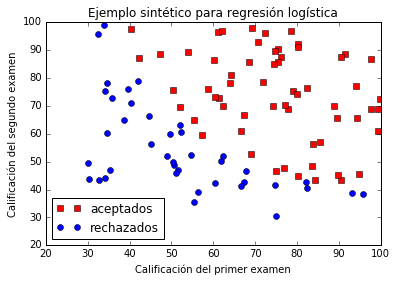

In [3]:
datos = np.loadtxt('admision.txt', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1:] 
x = np.c_[np.ones((x.shape[0], 1)), x]

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)

## 2. Generando atributos polinomiales

Como podemos ver en las gráficas de arriba, parece ser que la regresión logística aceptaría a algunos estudiantes rechazados y rechazaría a algunos que si fueron en realidad aceptados. En todo método de clasificación hay un grado de error, y eso es parte del poder de generalización de los métodos. 

Sin embargo, una simple inspección visual muestra que, posiblemente, la regresión lineal no es la mejor solución, ya que la frontera entre las dos clases parece ser más bien una curva.

¿Que tal si probamos con un clasificador cuadrático? Un clasificador cuadrático no es más que la regresión lineal pero a la que se le agregan todos los atributos que sean una combinación de dos de los atributos. 

Por ejemplo, si un objeto $x_e = (1, x_1, x_2, x_3)^T$ se aumenta con todas sus componentes cuadráticas, entonces tenemos los atributos

$$
\phi_2(x) = (1, x_1, x_2, x_3, x_1 x_2, x_1 x_3, x_2 x_3, x_1^2, x_2^2, x_3^2)^T.
$$ 

De la misma manera se pueden obtener clasificadores de orden tres, cuatro, cinco, etc. En general a estos clasificadores se les conoce como **clasificadores polinomiales**. Ahora, para entender bien la idea, vamos a resolver el problema anterior con un clasificador de orden 2. Sin embargo, si luego se quiere hacer el reconocimiento de otros objetos, o cambiar el orden del polinomio, pues se requeriría de reclcular cada vez la expansión polinomial a mano. Esto no es una muy buena práctica, así que vamos a generalizar la obtención de atributos polinomiales con la función `map_poly`, la cual la vamos a desarrollar a continuación.

In [4]:
from itertools import combinations_with_replacement

def map_poly(grad, x):
    """
    Encuentra las características polinomiales hasta el grado grad de la matriz de datos x, 
    asumiendo que x[:, 0] es la expansión de orden 0 (un vector de puros unos) y x[1:n, 0]
    es la expansión de orden 1 (los valores de cada atributo)
    
    @param grad: un entero positivo con el grado de expansión
    @param x: un ndarray de dimension (T, n + 1) donde n es el número de atributos
    
    @return: un ndarray de dimensión (T, n_phi + 1) donde
             n_phi = \sum_{i = 1}^grad fact(i + n - 1)/(fact(i) * fact(n - 1))
    """
    
    if int(grad) < 2:
        raise ValueError('grad debe de ser mayor a 1')
    
    T, n = x.shape[0], x.shape[1] - 1
    atrib = x[:,1:]
    x_phi = x.copy()
    for i in range(2, int(grad) + 1):
        for comb in combinations_with_replacement(range(n), i):
            x_phi = np.c_[x_phi, np.prod(atrib[:, comb], axis=1)]
    return x_phi        

#### Ejercicio 2: Realiza el clasificador polinomial de orden 2 de los datos de los exámenes (20 puntos)

## Prueba 1 
link = http://www.cs.cmu.edu/~aarti/Class/10701_Spring14/slides/linear_regression.pdf
## Prueba 2
ink = http://informatik.unibas.ch/fileadmin/Lectures/HS2015/mustererkennung/Folien/11_Non_Linear_Classifier_2.pdf

In [5]:
# Vamos a dar una guia paso a paso de lo que hay que hacer

# Encuentra phi_x (x son la expansión polinomial de segundo orden, utiliza la función map_poly
phi_x = map_poly(2, x)

# Genera la theta inicial
#theta_phi0 = np.linalg.pinv(x).dot(y)
theta_phi0 = np.linalg.pinv(phi_x).dot(y)

#Seguimos sin hacer refactoring y continuamos con las funciones parchadas
funcion = lambda theta, x, y: costo(theta.reshape(-1,1), x, y)
jacobiano = lambda theta, x, y: gradiente(theta.reshape(-1,1), x, y).ravel()

# Aplica la optimización
res = minimize(x0=theta_phi0,
               fun=funcion,
               args = (phi_x, y),
               method='Nelder-Mead',
               options= {'maxiter': 400, 'disp': True})
print res

 final_simplex: (array([[ -1.27367270e+02,   1.76289251e+00,   1.11577429e+00,
         -9.94328069e-03,   2.93314635e-03,  -4.66965920e-03],
       [ -1.27356045e+02,   1.75947115e+00,   1.11908867e+00,
         -9.91658100e-03,   2.92904542e-03,  -4.69284085e-03],
       [ -1.27274316e+02,   1.76712570e+00,   1.10821280e+00,
         -9.97345109e-03,   2.93633290e-03,  -4.61663434e-03],
       [ -1.27328194e+02,   1.75851198e+00,   1.11930528e+00,
         -9.90802246e-03,   2.92750960e-03,  -4.69572574e-03],
       [ -1.27284729e+02,   1.76185337e+00,   1.11394379e+00,
         -9.93487461e-03,   2.93055333e-03,  -4.65393228e-03],
       [ -1.27452265e+02,   1.76981337e+00,   1.11175599e+00,
         -9.99926089e-03,   2.94283770e-03,  -4.64528351e-03],
       [ -1.27315455e+02,   1.76518378e+00,   1.11156021e+00,
         -9.96275235e-03,   2.93503574e-03,  -4.63679556e-03]]), array([ 0.03538188,  0.03538383,  0.03538634,  0.03538699,  0.0353874 ,
        0.03538907,  0.0353892 ]))

/home/juanmanuel/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log
/home/juanmanuel/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in multiply


El reusltado debe de ser algo similar a:

$$
\theta_\phi = (15.87, -428.13, -110.51, 1.63, -0.8889, 8.6)^T
$$

Y esto lo tenemos que graficar. Pero graficar la separación de datos en una proyección en las primeras dos dimensiones, no es tan sencillo como 
lo hicimos con una separación lineal, así que vamos atener que generar un `contour`, y sobre este graficar los datos. Para esto vamos a desarrollar una función (esta la hago yo porque es un poco dificil y no da luz sobre los temas escenciales).

In [6]:
def plot_separacion2D(x, y, grado, theta_phi):
    """
    Grafica las primeras dos dimensiones (posiciones 1 y 2) de datos en dos dimensiones 
    extendidos con un clasificador polinomial así como la separación dada por theta_phi
    
    """
    if grado < 2:
        raise ValueError('Esta funcion es para graficar separaciones con polinomios mayores a 1')
    
    x1_min, x1_max = np.min(x[:,1]), np.max(x[:,1])
    x2_min, x2_max = np.min(x[:,2]), np.max(x[:,2])
    delta1, delta2 = (x1_max - x1_min) * 0.1, (x2_max - x2_min) * 0.1

    spanX1 = np.linspace(x1_min - delta1, x1_max + delta1, 200)
    spanX2 = np.linspace(x2_min - delta2, x2_max + delta2, 200)
    X1, X2 = np.meshgrid(spanX1, spanX2)
        
    #Z = np.zeros_like(X1)
    #for (i, x1) in enumerate(spanX1):
    #    for (j, x2) in enumerate(spanX2):
    #        Z[i,j] = float(map_poly(grado, np.array([[1, x1, x2]])).dot(theta_phi))
    Z = map_poly(grado, np.c_[np.ones((X1.size, 1)), X1.ravel(), X2.ravel()]).dot(theta_phi)
    Z = Z.reshape(X1.shape[0], X1.shape[1])
    
    plt.contour(X1, X2, Z, [0], linewidths=0.5, colors='k')
    plt.contourf(X1, X2, Z, 1, cmap=plt.cm.gray)
    plt.plot(x[y.ravel() > 0.5, 1], x[y.ravel() > 0.5, 2], 'sr', label='aceptados')
    plt.plot(x[y.ravel() < 0.5, 1], x[y.ravel() < 0.5, 2], 'oy', label='rechazados')
    plt.axis([spanX1[0], spanX1[-1], spanX2[0], spanX2[-1]])

Y ahora vamos a probar la función `plot_separacion2D` con los datos de entrenamiento. El comando tarda, ya que estamos haciendo un grid de 200 $\times$ 200, y realizando evaluaciones individuales. 

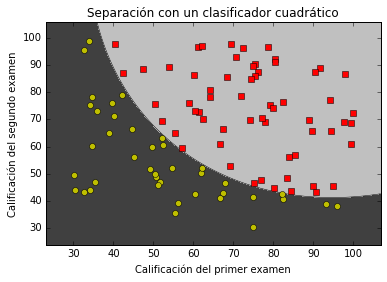

In [7]:
plot_separacion2D(x, y, 2, res.x.reshape(-1,1))
plt.title(u"Separación con un clasificador cuadrático")
plt.xlabel(u"Calificación del primer examen")
plt.ylabel(u"Calificación del segundo examen")

Muy bien, un clasificador polinomial de orden 2 clasifica perfectamente los datos de aprendizaje, y además parece suficientemente simple para ser la mejor opción para hacer la predicción.

Tomemos ahora una base de datos que si bien es sintética es representativa de una familia de problemas a resolver. Supongamos que estámos opimizando la fase de pruebas dentro de la linea de producción de la empresa *Microprocesadores del Noroeste S.A. de C.V.*. La idea es reducir el banco de pruebas de cada nuevo microprocesador fabricado y en lugar de hacer 50 pruebas, reducirlas a 2. En el conjunto de datos tenemos los valores que sacó cada componente en las dos pruebas seleccionadas, y la decisión que se tomo con cada dispositivo (esta desición se tomo con el banco de 50 reglas). Los datos los podemos visualizar a continuación.

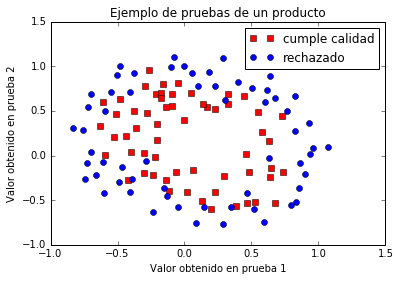

In [8]:
datos = np.loadtxt('prod_test.txt', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1:] 
x = np.c_[np.ones((x.shape[0], 1)), x]

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='cumple calidad') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazado')
plt.title(u'Ejemplo de pruebas de un producto')
plt.xlabel(u'Valor obtenido en prueba 1')
plt.ylabel(u'Valor obtenido en prueba 2')
#plt.axis([20, 100, 20, 100])
plt.legend(loc=0)

Cláramente este problema no se puede solucionar con un clasificador lineal (1 orden), por lo que hay que probar otros tipos de clasificadores.

#### Ejercicio 3: Prueba hacer regresión polinomial para polinomios de orden 2, 4, 6 y 8, y grafica los resultados en una figura cada uno. Recuerda que este ejercicio puede tomar bastante tiempo de cómputo dependiendo tanto del método de optimización seleccionado como de la graficacion, al final agrega una celda de texto donde comentes los resultados (20 puntos).

ValueError: shapes (40000,15) and (6,1) not aligned: 15 (dim 1) != 6 (dim 0)

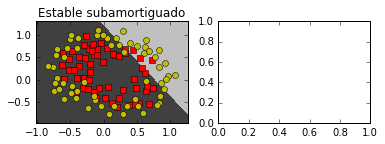

In [9]:
# Vamos a hacer una pequeña funcion para hacer todo de forma más fácil

def aprende_polinomial(x, y, grado):
    """
    Aprende un clasificador polinomial para el conjunto de aprendizaje dado por x (ya extendida) y y
    
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: theta_phi un ndarray con los valores necesarios para theta etendida en el espacio de x_phi.
    
    """
    #-------------------------------------------------------------------------------------------------------
    # Agrega tu codiggo aqui
    #
    # Para este caso te recomiendo utilizar el método BFGS
    #---------------------------------------------------------------------------------------------------------
    theta_phi = minimize(x0=theta_phi0,
                   fun=funcion,
                   args = (phi_x, y),
                   method='BFGS',
                   options= {'maxiter': 400, 'disp': True})
    
    
    return theta_phi
    #----------------------------------------------------------------------------------------------------------
    
    
#-----------------------------------------------------------------------------------
# Ahora vamos a utilizar esto para graficar las diferentes curvas
#
#for grado in [2, 4, 6, 8]:
    #------------------------------------------------
    # agregar aqui tu código
    #------------------------------------------------

    
    
    #------------------------------------------------
plt.subplot(2, 2, 1)
plot_separacion2D(x, y, 2, res.x.reshape(-1,1))
plt.title('Estable subamortiguado')

plt.subplot(2, 2, 2)
plot_separacion2D(x, y, 4, res.x.reshape(-1,1))
plt.title('Criticamente estable')

plt.subplot(2, 2, 3)
plot_separacion2D(x, y, 6, res.x.reshape(-1,1))
plt.title('inestable')

plt.subplot(2, 2, 4)
plot_separacion2D(x, y, 8, res.x.reshape(-1,1))
plt.title('Estable sobreamortiguado')

Y para dar una gui de lo que se espera, anexo las imágenes de las gráficas para el polinomio de orden 2 y para el polinomio de orden 8. 

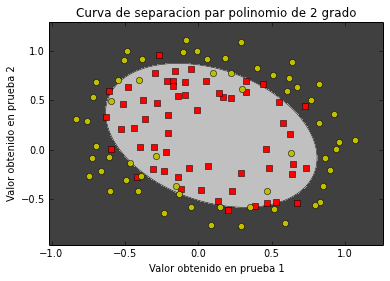

In [10]:
Image(filename='ejemplo_logistica_2.png')

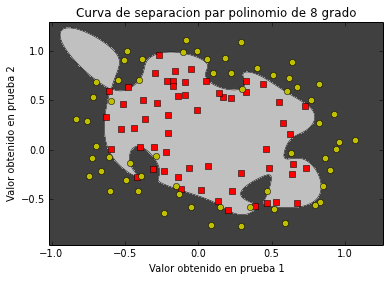

In [11]:
Image(filename='ejemplo_logistica_3.png')

## 3. Regularización

Como podemos ver del ejercicio anterior, es dificil determinar el grado del polinomio, y en algunos casos es demasiado general (subaprendizaje) y en otros demasiado específico (sobreaprendizaje). ¿Que podría ser la solución?, bueno, una solución posible es utilizar un polinomio de alto grado (o relativamente alto), y utilizar la **regularización** para controlar la generalización del algoritmo, a través de una variable $\lambda$.

Recordemos, la función de costos de la regresión logística con regularización es:

$$
J(\theta) = -\frac{1}{T} \sum_{i=1}^T \left[ y^{(i)}\log(h_\theta(x^{(i)}) + (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))\right] + \frac{\lambda}{2T}\sum_{j = 1}^n \theta_j^2,
$$

que es básicamente la misma que la función de costo original, pero además se le suma el una constante por el promedio del cuadrado de los parámetros (a excepción de $\theta_0$).

#### Ejercicio 4: Desarrolla sin utilizar ciclos `for` la forma de calcular el costo para el problema de regresión lineal regularizada (15 puntos).

In [12]:
def costo_regularizado(theta, x, y, lammbda):
    """
    Función de costo con regularización para la regresión logística para los parámetros theta con
    el conjunto de entrenamiento dado por x y y, y la constante de regularización lambda.
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param lammbda: un escalar mayor o igual a 0 (o 0.0)
    
    @return: un flotante con el costo
    
    """ 
    #---------------------------------------------------------------------------------------
    # Inserta aquí tu código
    T = x.shape[0]
    costo = -((np.sum(y * np.log(logistica(x.dot(theta))) + (1 - y) * (np.log(1 - logistica(x.dot(theta)))))) / T)
    regularizacion = (np.sum(theta**2)) * (lammbda / 2 * T)
    return costo + regularizacion
    #----------------------------------------------------------------------------------------
    
# Y para probarlo vamos a hacer un uittest de lo mas sencillo, utilizando la base de datos 
# que tenemos actualmente cargada (prod_test.txt) 

phi_x = map_poly(6, x)
theta_prueba = np.zeros((phi_x.shape[1], 1))

print abs(costo_regularizado(theta_prueba, phi_x, y, 1) - 0.693) <= 0.001
assert abs(costo_regularizado(theta_prueba, phi_x, y, 1) - 0.693) <= 0.001

True


Y, por supuesto, para poder utilizar un algoritmo eficiente de optimización, debemos ser capaces de calcular el gradiente de la función.

#### Ejercicio 5: Desarrolla, aprovechando al máximo de las ventajas de ndarrays, la función del gradiente con regularización (15 puntos).

In [13]:
def gradiente_regularizado(theta, x, y, lammbda):
    """
    Calcula el gradiente del costo de la regresión logística, para una theta, conociendo un conjunto de aprendizaje
    y con regularización.
    
    @param theta: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param lammbda: un escalar mayor o igual a 0 (o 0.0)
    
    @return: un ndarray de mismas dimensiones que theta
    
    """
    T = x.shape[0]

    #------------------------------------------------------------------------
    # Agregua aqui tu código
    #------------------------------------------------------------------------
    gradiente = ((x.T.dot(logistica(x.dot(theta)) - y)) / T)
    regularizacion = (np.sum(theta**2)) * (lammbda / 2 * T)
    return gradiente + regularizacion
    #------------------------------------------------------------------------
     
# Y para probar vamos a hacer esto:
phi_x = map_poly(6, x)
theta_prueba = np.zeros((phi_x.shape[1], 1))
grad_theta_prueba = gradiente_regularizado(theta_prueba, phi_x, y, 1)

print abs(grad_theta_prueba[0] - 8.47e-3) < 1e-5
print abs(grad_theta_prueba[5] - 3.76e-2) < 1e-4
print abs(grad_theta_prueba[-1] - 3.88e-2) < 1e-4

assert abs(grad_theta_prueba[0] - 8.47e-3) < 1e-5
assert abs(grad_theta_prueba[5] - 3.76e-2) < 1e-4
assert abs(grad_theta_prueba[-1] - 3.88e-2) < 1e-4

[ True]
[ True]
[ True]


Y ya por último queda probar la regresión logística con regularización, por lo que vamos a generar 3 superficies: una *aceptable*, otra con sobreaprendizaje y la última con subaprendizaje.

#### Ejercicio 6: Desarrolla las funciones y scriprs necesarios para realizar la regresión logística con un polinomio de grado 8 y con regularización. Grafica la superficie de separación para $\lambda$ igual a 1 (*aceptable*), 0 (*sobreaprendizaje*), 200 (*subaprendizaje*) (20 puntos)

In [14]:
# Aqui pues ya no agrego nada de código para guiar el trabajo ya que es 
# relativamente bastante parecido a lo que se hizo en la sección anterior.



Y de nuevo, como forma de verificar si lo están haciendo bien o no, incluyo dos de las tres figuras que deben obtener, tl como yo las obtuve.

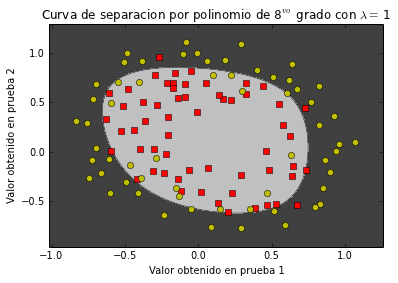

In [15]:
Image(filename='ejemplo_logistica_4.png')

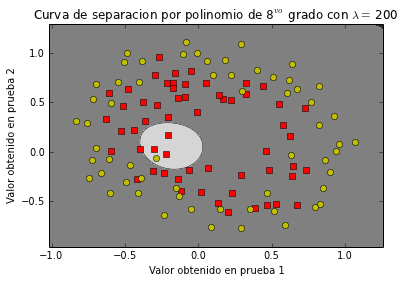

In [16]:
Image(filename='ejemplo_logistica_5.png')